## HMM实现中文分词

### 计算PI,A,B。
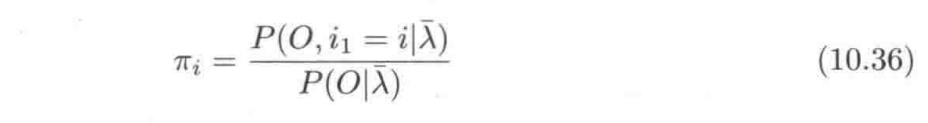
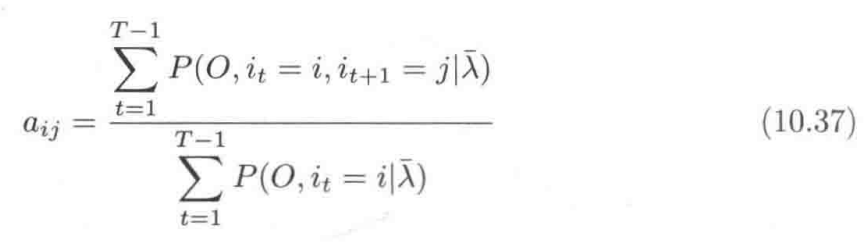
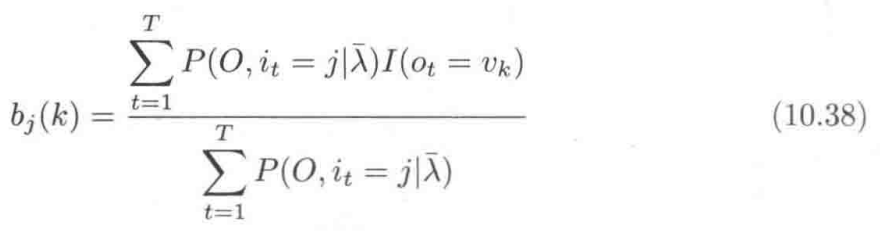

In [1]:
def trainParameter(fileName):
    '''
    依据训练文本统计PI、A、B
    :param fileName: 训练文本
    :return: 三个参数
    '''
    #定义一个查询字典，用于映射四种标记在数组中对应的位置，方便查询
    # B：词语的开头
    # M：一个词语的中间词
    # E：一个词语的结尾
    # S：非词语，单个词
    statuDict = {'B':0, 'M':1, 'E':2, 'S':3}

    #每个字只有四种状态，所以下方的各类初始化中大小的参数均为4
    #初始化PI的一维数组，因为对应四种状态，大小为4
    PI = np.zeros(4)
    #初始化状态转移矩阵A，涉及到四种状态各自到四种状态的转移，因为大小为4x4
    A = np.zeros((4, 4))
    #初始化观测概率矩阵，分别为四种状态到每个字的发射概率
    #因为是中文分词，使用ord(汉字)即可找到其对应编码，这里用一个65536的空间
    #来保证对于所有的汉字都能
    #找到对应的位置来存储
    B = np.zeros((4, 65536))
    #去读训练文本
    fr = open(fileName, encoding='utf-8')

    #文本中的每一行认为是一个训练样本
    #在统计上，三个参数依据“10.3.2” Baum-Welch算法内描述的统计
    #PI依据式10.36
    #A依据10.37
    #B依据10.38
    #注：并没有使用Baum-Welch算法，只是借助了其内部的三个参数生成公式，其实
    #公式并不是Baum-Welch特有的，只是在那一节正好有描述
    for line in fr.readlines():
        #---------------------训练集单行样例--------------------
        #深圳  有  个  打工者  阅览室
        #------------------------------------------------------
        #可以看到训练样本已经分词完毕，词语之间空格隔开，因此我们在生成统计
        #时主要借助以下思路：
        # 1.先将句子按照空格隔开，例如例句中5个词语，隔开后变成一个长度为5
        #的列表，每个元素为一个词语
        # 2.对每个词语长度进行判断：
        #       如果为1认为该词语是S，即单个字
        #       如果为2则第一个是B，表开头，第二个为E，表结束
        #       如果大于2，则第一个为B，最后一个为E，中间全部标为M，表中间词
        # 3.统计PI：该句第一个字的词性对应的PI中位置加1
        #           例如：PI = [0， 0， 0， 0]，当本行第一个字是B，即表示开
        #头时，PI中B对应位置为0，
        #               则PI = [1， 0， 0， 0]，全部统计结束后，按照计数值
        #再除以总数得到概率
        #   统计A：对状态链中位置t和t-1的状态进行统计，在矩阵中相应位置加1，
        #全部结束后生成概率
        #   统计B：对于每个字的状态以及字内容，生成状态到字的发射计数，全部
        #结束后生成概率
        #   注：可以看一下“10.1.1 隐马尔可夫模型的定义”一节中三个参数的定
        #义，会有更清晰一点的认识
        #-------------------------------------------------------
        #对单行句子按空格进行切割
        curLine = line.strip().split()
        #对词性的标记放在该列表中
        wordLabel = []
        #对每一个单词进行遍历
        for i in range(len(curLine)):
            #如果长度为1，则直接将该字标记为S，即单个词
            if len(curLine[i]) == 1:
                label = 'S'
            else:
                #如果长度不为1，开头为B，最后为E，中间添加长度-2个M
                #如果长度刚好为2，长度-2=0也就不添加了，反之添加对应个数的M
                label = 'B' + 'M' * (len(curLine[i]) - 2) + 'E'

            #如果是单行开头第一个字，PI中对应位置加1,
            if i == 0: PI[statuDict[label[0]]] += 1

            #对于该单词中的每一个字，在生成的状态链中统计B
            for j in range(len(label)):
                #遍历状态链中每一个状态，并找到对应的中文汉字，在B中
                #对应位置加1
                B[statuDict[label[j]]][ord(curLine[i][j])] += 1

            #在整行的状态链中添加该单词的状态链
            #注意：extend表直接在原先元素的后方添加，
            #可以百度一下extend和append的区别
            wordLabel.extend(label)

        #单行所有单词都结束后，统计A信息
        #因为A涉及到前一个状态，因此需要等整条状态链都生成了才能开始统计
        for i in range(1, len(wordLabel)):
            #统计t时刻状态和t-1时刻状态的所有状态组合的出现次数
            A[statuDict[wordLabel[i - 1]]][statuDict[wordLabel[i]]] += 1

    #上面代码在统计上全部是统计的次数，实际运算需要使用概率，
    #下方代码是将三个参数的次数转换为概率
    #----------------------------------------
    #对PI求和，概率生成中的分母
    sum = np.sum(PI)
    #遍历PI中每一个元素，元素出现的次数/总次数即为概率
    for i in range(len(PI)):
        #如果某元素没有出现过，该位置为0，在后续的计算中这是不被允许的
        #比如说某个汉字在训练集中没有出现过，那在后续不同概率相乘中只要有
        #一项为0，其他都是0了，此外整条链很长的情况下，太多0-1的概率相乘
        #不管怎样最后的结果都会很小，很容易下溢出
        #所以在概率上我们习惯将其转换为log对数形式，这在书上是没有讲的
        #x大的时候，log也大，x小的时候，log也相应小，我们最后比较的是不同
        #概率的大小，所以使用log没有问题

        #那么当单向概率为0的时候，log没有定义，因此需要单独判断
        #如果该项为0，则手动赋予一个极小值
        if PI[i] == 0:  PI[i] = -3.14e+100
        #如果不为0，则计算概率，再对概率求log
        else: PI[i] = np.log(PI[i] / sum)

    #与上方PI思路一样，求得A的概率对数
    for i in range(len(A)):
        sum = np.sum(A[i])
        for j in range(len(A[i])):
            if A[i][j] == 0: A[i][j] = -3.14e+100
            else: A[i][j] = np.log(A[i][j] / sum)

    #与上方PI思路一样，求得B的概率对数
    for i in range(len(B)):
        sum = np.sum(B[i])
        for j in range(len(B[i])):
            if B[i][j] == 0: B[i][j] = -3.14e+100
            else:B[i][j] = np.log(B[i][j] / sum)

    #返回统计得到的三个参数
    return PI, A, B

In [2]:
def loadArticle(fileName):
    '''
    加载文章
    :param fileName:文件路径
    :return: 文章内容
    '''
    #初始化文章列表
    artical = []
    #打开文件
    fr = open(fileName, encoding='utf-8')
    #按行读取文件
    for line in fr.readlines():
        #读到的每行最后都有一个\n，使用strip将最后的回车符去掉
        line = line.strip()
        #将该行放入文章列表中
        artical.append(line)
    #将文章返回
    return artical

### 维特比算法
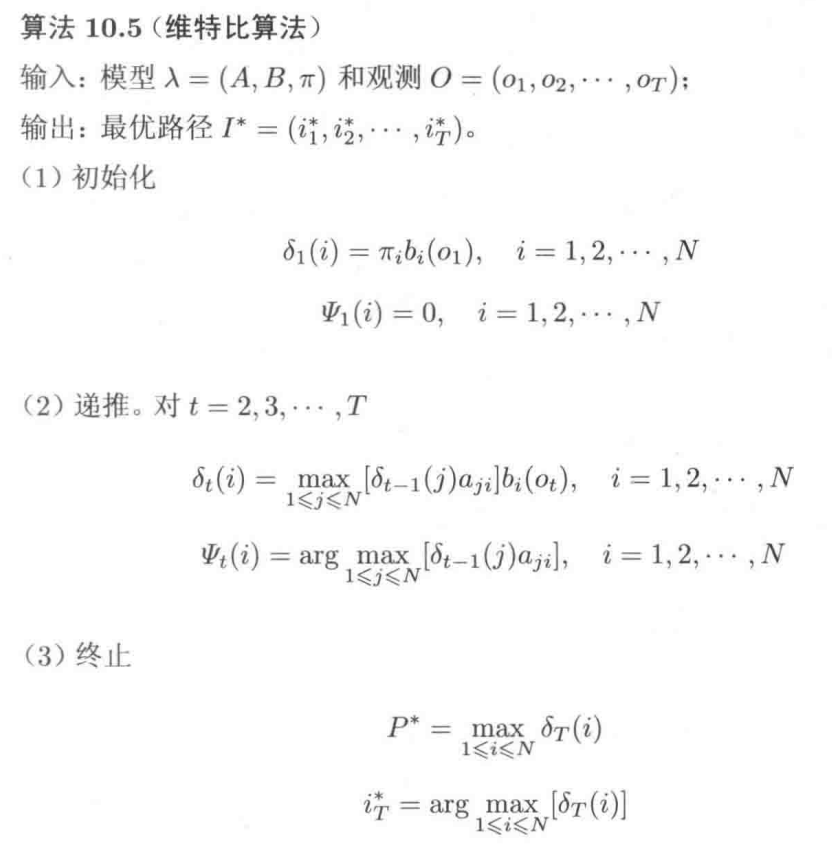
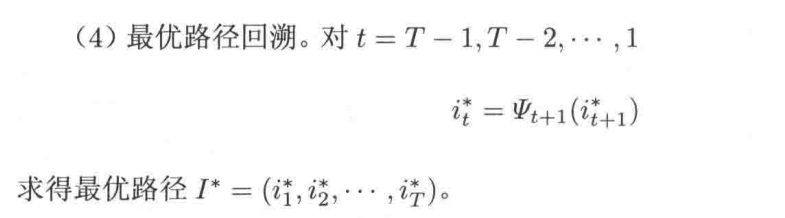

In [3]:
def participle(artical, PI, A, B):
    '''
    分词
    算法依据“10.4.2 维特比算法”
    :param artical:要分词的文章
    :param PI: 初始状态概率向量PI
    :param A: 状态转移矩阵
    :param B: 观测概率矩阵
    :return: 分词后的文章
    '''
    #初始化分词后的文章列表
    retArtical = []

    #对文章按行读取
    for line in artical:
        #初始化δ，δ存放四种状态的概率值，因为状态链中每个状态都有
        #四种概率值，因此长度时该行的长度
        delta = [[0 for i in range(4)] for i in range(len(line))]
        #依据算法10.5 第一步：初始化
        for i in range(4):
            #初始化δ状态链中第一个状态的四种状态概率
            delta[0][i] = PI[i] + B[i][ord(line[0])]
        #初始化ψ，初始时为0
        psi = [[0 for i in range(4)] for i in range(len(line))]

        #算法10.5中的第二步：递推
        #for循环的符号与书中公式一致，可以对比着看来理解
        #依次处理整条链
        for t in range(1, len(line)):
            #对于链中的米格状态，求四种状态概率
            for i in range(4):
                #初始化一个临时列表，用于存放四种概率
                tmpDelta = [0] * 4
                for j in range(4):
                    # 计算第二步中的δ，该部分只计算max内部，不涉及后面的bi(o)
                    # 计算得到四个结果以后，再去求那个max即可
                    # 注：bi(Ot)并不在max的式子中，是求出max以后再乘b的
                    #   此外读者可能注意到书中的乘法在这里变成了加法，这是由于
                    #原先是概率
                    #   直接相乘，但我们在求得概率时，同时取了log，取完log以后，
                    #概率的乘法
                    #   也就转换为加法了，同时也简化了运算
                    #   所以log优点还是很多的对不？
                    tmpDelta[j] = delta[t - 1][j] + A[j][i]

                #找到最大的那个δ * a，
                maxDelta = max(tmpDelta)
                #记录最大值对应的状态
                maxDeltaIndex = tmpDelta.index(maxDelta)

                #将找到的最大值乘以b放入，
                #注意：这里同样因为log变成了加法
                delta[t][i] = maxDelta + B[i][ord(line[t])]
                #在ψ中记录对应的最大状态索引
                psi[t][i] = maxDeltaIndex

        #建立一个状态链列表，开始生成状态链
        sequence = []
        #算法10.5 第三步：终止
        #在上面for循环全部结束后，很明显就到了第三步了
        #获取最后一个状态的最大状态概率对应的索引
        i_opt = delta[len(line) - 1].index(max(delta[len(line) - 1]))
        #在状态链中添加索引
        #注：状态链应该是B、M、E、S，这里图方便用了0、1、2、3，其实一样的
        sequence.append(i_opt)
        #算法10.5 第四步：最优路径回溯
        #从后往前遍历整条链
        for t in range(len(line) - 1, 0, -1):
            #不断地从当前时刻t的ψ列表中读取到t-1的最优状态
            i_opt = psi[t][i_opt]
            #将状态放入列表中
            sequence.append(i_opt)
        #因为是从后往前将状态放入的列表，所以这里需要翻转一下，变成了从前往后
        sequence.reverse()

        #开始对该行分词
        curLine = ''
        #遍历该行每一个字
        for i in range(len(line)):
            #在列表中放入该字
            curLine += line[i]
            #如果该字是3：S->单个词  或  2:E->结尾词 ，则在该字后面加上分隔符 |
            #此外如果改行的最后一个字了，也就不需要加 |
            if (sequence[i] == 3 or sequence[i] == 2) and i != (len(line) - 1):
                curLine += '|'
        #在返回列表中添加分词后的该行
        retArtical.append(curLine)
    #返回分词后的文章
    return retArtical

## HMM实现词性标注

* 转移概率矩阵大小为 $44\times44$，发射概率矩阵大小为 $44\times分词词串数目$，两者都是在程序运行时生成。
* 若在大规模词性标注情况下建议保存 $44\times44$ 和 $44\times60366$ (语料库总词数)大小的转移概率矩阵和发射概率矩阵到本地文件中，需要时直接一次读取该文件存入内存而不需动态生成，提高效率。
* 在计算转移概率时是以句子为单位进行处理的，因此，对于一段文字建议按标点分成几个句子处理，一来能提高词性标注的准确性，二来防止因句子长度过长出现下溢现象。

In [4]:
def cal_hmm_matrix(observation):
    # 得到所有标签
    word_pos_file = open('ChineseDic.txt').readlines()
    tags_num = {}
    for line in word_pos_file:
        word_tags = line.strip().split(',')[1:]
        for tag in word_tags:
            if tag not in tags_num.keys():
                tags_num[tag] = 0
    tags_list = list(tags_num.keys())

    # 转移矩阵、发射矩阵
    transaction_matrix = np.zeros((len(tags_list), len(tags_list)), dtype=float)
    emission_matrix = np.zeros((len(tags_list), len(observation)), dtype=float)

    # 计算转移矩阵和发射矩阵
    word_file = open('199801.txt').readlines()
    for line in word_file:
        if line.strip() != '':
            word_pos_list = line.strip().split('  ')
            for i in range(1, len(word_pos_list)):
                tag = word_pos_list[i].split('/')[1]
                pre_tag = word_pos_list[i - 1].split('/')[1]
                try:
                    transaction_matrix[tags_list.index(pre_tag)][tags_list.index(tag)] += 1
                    tags_num[tag] += 1
                except ValueError:
                    if ']' in tag:
                        tag = tag.split(']')[0]
                    else:
                        pre_tag = tag.split(']')[0]
                    transaction_matrix[tags_list.index(pre_tag)][tags_list.index(tag)] += 1
                    tags_num[tag] += 1

            for o in observation:
                # 注意这里用in去找（' 我/'，' **我/'的区别），用空格和‘/’才能把词拎出来
                if ' ' + o in line:
                    pos_tag = line.strip().split(o)[1].split('  ')[0].strip('/')
                    if ']' in pos_tag:
                        pos_tag = pos_tag.split(']')[0]
                    emission_matrix[tags_list.index(pos_tag)][observation.index(o)] += 1

    for row in range(transaction_matrix.shape[0]):
        n = np.sum(transaction_matrix[row])
        transaction_matrix[row] += 1e-16
        transaction_matrix[row] /= n + 1

    for row in range(emission_matrix.shape[0]):
        emission_matrix[row] += 1e-16
        emission_matrix[row] /= tags_num[tags_list[row]] + 1

    times_sum = sum(tags_num.values())
    for item in tags_num.keys():
        tags_num[item] = tags_num[item] / times_sum

    # 返回隐状态，初始概率pi，转移概率A，发射矩阵概率B
    return tags_list, list(tags_num.values()), transaction_matrix, emission_matrix

### 算法描述
* 构造两个矩阵，max_p每一列为当前观测序列不同隐状态的最大概率；path每一行存储上max_p对应列的路径，用于回溯；
* 初始化max_p第1个观测节点不同隐状态的最大概率并初始化path从各个隐状态出发；
* 遍历第1项后的每一个观测序列，计算其不同隐状态的最大概率，计算公式为$v_t(j)=max(v_{t-1}(i)\times a_{ij})\times b_j(o_t)$；
* 记录最大概率及路径，用新的路径覆盖之前的路径；
* 到达最后一个观测节点，比较并返回概率最大的路径，从path中取出。

In [5]:
def viterbi(obs_len, states_len, init_p, trans_p, emit_p):
    """
    :param obs_len: 观测序列长度 int
    :param states_len: 隐含序列长度 int
    :param init_p:初始概率 list
    :param trans_p:转移概率矩阵 np.ndarray
    :param emit_p:发射概率矩阵 np.ndarray
    :return:最佳路径 np.ndarray
    """
    max_p = np.zeros((states_len, obs_len))  # max_p每一列为当前观测序列不同隐
    #状态的最大概率
    path = np.zeros((states_len, obs_len))  # path每一行存储上max_p对应列的路径

    # 初始化max_p第1个观测节点不同隐状态的最大概率并初始化path从各个隐状态出发
    for i in range(states_len):
        max_p[i][0] = init_p[i] * emit_p[i][0]
        path[i][0] = i

    # 遍历第1项后的每一个观测序列，计算其不同隐状态的最大概率
    for obs_index in range(1, obs_len):
        new_path = np.zeros((states_len, obs_len))
        # 遍历其每一个隐状态
        for hid_index in range(states_len):
            # 根据公式计算累计概率，得到该隐状态的最大概率
            max_prob = -1
            pre_state_index = 0
            for i in range(states_len):
                each_prob = max_p[i][obs_index - 1] * trans_p[i][hid_index] * \
                emit_p[hid_index][obs_index]
                if each_prob > max_prob:
                    max_prob = each_prob
                    pre_state_index = i

            # 记录最大概率及路径
            max_p[hid_index][obs_index] = max_prob
            for m in range(obs_index):
                # "继承"取到最大概率的隐状态之前的路径（从之前的path中取出某条路径）
                new_path[hid_index][m] = path[pre_state_index][m]
            new_path[hid_index][obs_index] = hid_index
        # 更新路径
        path = new_path

    # 返回最大概率的路径
    max_prob = -1
    last_state_index = 0
    for hid_index in range(states_len):
        if max_p[hid_index][obs_len - 1] > max_prob:
            max_prob = max_p[hid_index][obs_len - 1]
            last_state_index = hid_index
    return path[last_state_index]

In [6]:
import numpy as np
PI, A, B = trainParameter('HMMTrainSet.txt')
#读取测试文章
artical = loadArticle('testArtical.txt')
#打印原文
print('-------------------原文----------------------')
for line in artical:
    print(line)
#进行分词
partiArtical = participle(artical, PI, A, B)
#打印分词结果
print('-------------------分词后----------------------')
for line in partiArtical:
    print(line)

-------------------原文----------------------
月影轻移，
寂静如雾缓缓漫开。
一颗被抚慰得微醺的心，
诠释一种千年的期待。
玄奥在地下深埋，
现实的顿悟却被描出形来。
那音韵如轻柔的夜风，
惊溅起不可言传的天籁。
怀揣这如泣如诉的呵护，
才发觉已迷失了来路。
-------------------分词后----------------------
月|影轻移|，
寂静|如雾|缓缓|漫开|。
一|颗|被|抚慰|得|微醺|的|心|，
诠释|一种|千年|的|期待|。
玄奥|在|地下|深埋|，
现实|的|顿悟|却|被|描出|形来|。
那|音韵|如轻柔|的|夜风|，
惊溅|起|不|可言传|的|天籁|。
怀|揣|这|如泣|如诉|的|呵护|，
才|发觉|已|迷失|了|来路|。


In [7]:
print('PI:',PI.shape,'A:',A.shape,'B:',B.shape)

PI: (4,) A: (4, 4) B: (4, 65536)


In [8]:
print('-------------------标注后----------------------')
for line in partiArtical:
    obs = [i+'/' for i in line.split('|')]
    hid, init_p, trans_p, emit_p = cal_hmm_matrix(obs)
    result = viterbi(len(obs), len(hid), init_p, trans_p, emit_p)
    tag_line = ''
    for k in range(len(result)):
        tag_line += obs[k] + hid[int(result[k])] + ' '
    print(tag_line)

-------------------标注后----------------------
月/t 影轻移/Tg ，/w 
寂静/a 如雾/w 缓缓/d 漫开/Vg 。/w 
一/m 颗/q 被/p 抚慰/v 得/u 微醺/v 的/u 心/n ，/w 
诠释/v 一种/Rg 千年/Rg 的/u 期待/vn 。/w 
玄奥/a 在/p 地下/s 深埋/e ，/w 
现实/n 的/u 顿悟/vn 却/d 被/p 描出/Rg 形来/Rg 。/w 
那/r 音韵/n 如轻柔/k 的/u 夜风/n ，/w 
惊溅/ad 起/v 不/d 可言传/a 的/u 天籁/n 。/w 
怀/v 揣/v 这/r 如泣/o 如诉/o 的/u 呵护/vn ，/w 
才/d 发觉/v 已/d 迷失/v 了/u 来路/n 。/w 


In [9]:
obs = ['我/','是/','中国/','人/']
hid, init_p, trans_p, emit_p = cal_hmm_matrix(obs)
result = viterbi(len(obs), len(hid), init_p, trans_p, emit_p)
tag_line = ''
for k in range(len(result)):
    tag_line += obs[k] + hid[int(result[k])] + ' '
print(tag_line)

我/r 是/v 中国/ns 人/n 


In [10]:
print('hid:',hid)
print('init_p:',len(init_p),'\ntrans_p:',trans_p.shape,'\nemit_p:',emit_p.shape)
print('result:',result)

hid: ['nr', 'v', 'w', 'm', 'nz', 'nt', 'nx', 'q', 'ns', 't', 'n', 'l', 'j', 'y', 'e', 'b', 'd', 'i', 'an', 'vn', 'a', 'z', 'Ag', 'ad', 'r', 'p', 's', 'Ng', 'Vg', 'o', 'u', 'f', 'Dg', 'c', 'vd', 'k', 'Tg', 'Mg', 'Bg', 'Yg', 'h', 'Rg', 'vvn', 'na']
init_p: 44 
trans_p: (44, 44) 
emit_p: (44, 4)
result: [24.  1.  8. 10.]


### 参考

<div id="refer-anchor-1"></div>

- [1] [csdn自然语言处理](https://blog.csdn.net/chase1998/category_8243276.html)

<div id="refer-anchor-2"></div>

- [2] [github](https://github.com/Dod-o/Statistical-Learning-Method_Code/tree/master/HMM)